Loaded validation data: (5621, 256, 256) predictions, (5621, 256, 256) ground truth masks



Testing thresholds: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Optimal threshold: 0.637 with Dice coefficient: 0.9667

Threshold results:
    Threshold  Mean_Dice
0    0.400000   0.392585
1    0.415789   0.392585
2    0.431579   0.392585
3    0.447368   0.392585
4    0.463158   0.392585
5    0.478947   0.392585
6    0.494737   0.392585
7    0.510526   0.952464
8    0.526316   0.960396
9    0.542105   0.962956
10   0.557895   0.964353
11   0.573684   0.965248
12   0.589474   0.965998
13   0.605263   0.966177
14   0.621053   0.966571
15   0.636842   0.966673
16   0.652632   0.965958
17   0.668421   0.964925
18   0.684211   0.963631
19   0.700000   0.961656


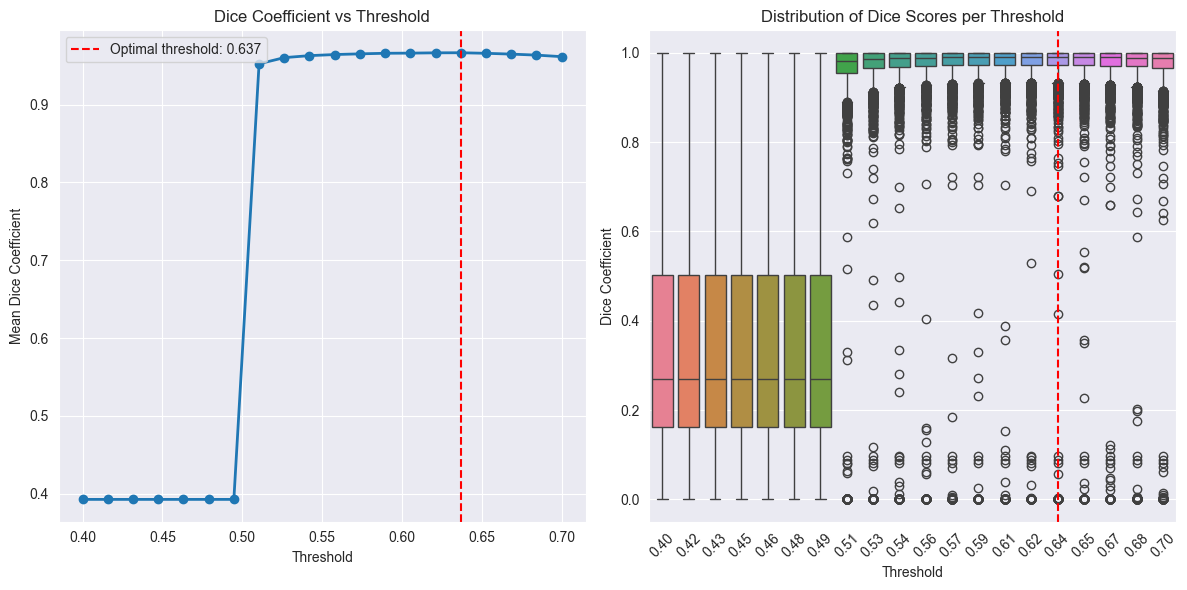

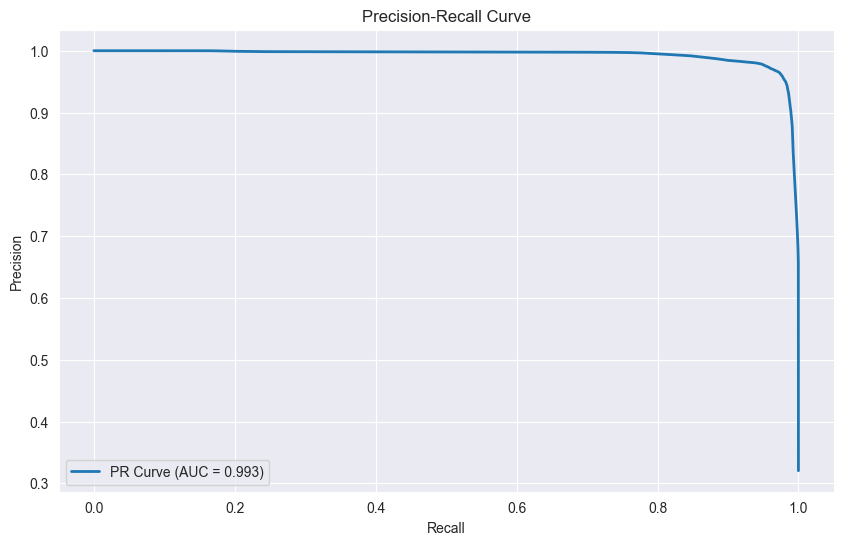

Exception ignored in: <function tqdm.__del__ at 0x0000023E5B392700>
Traceback (most recent call last):
  File "E:\cv_hackathon\.venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "E:\cv_hackathon\.venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


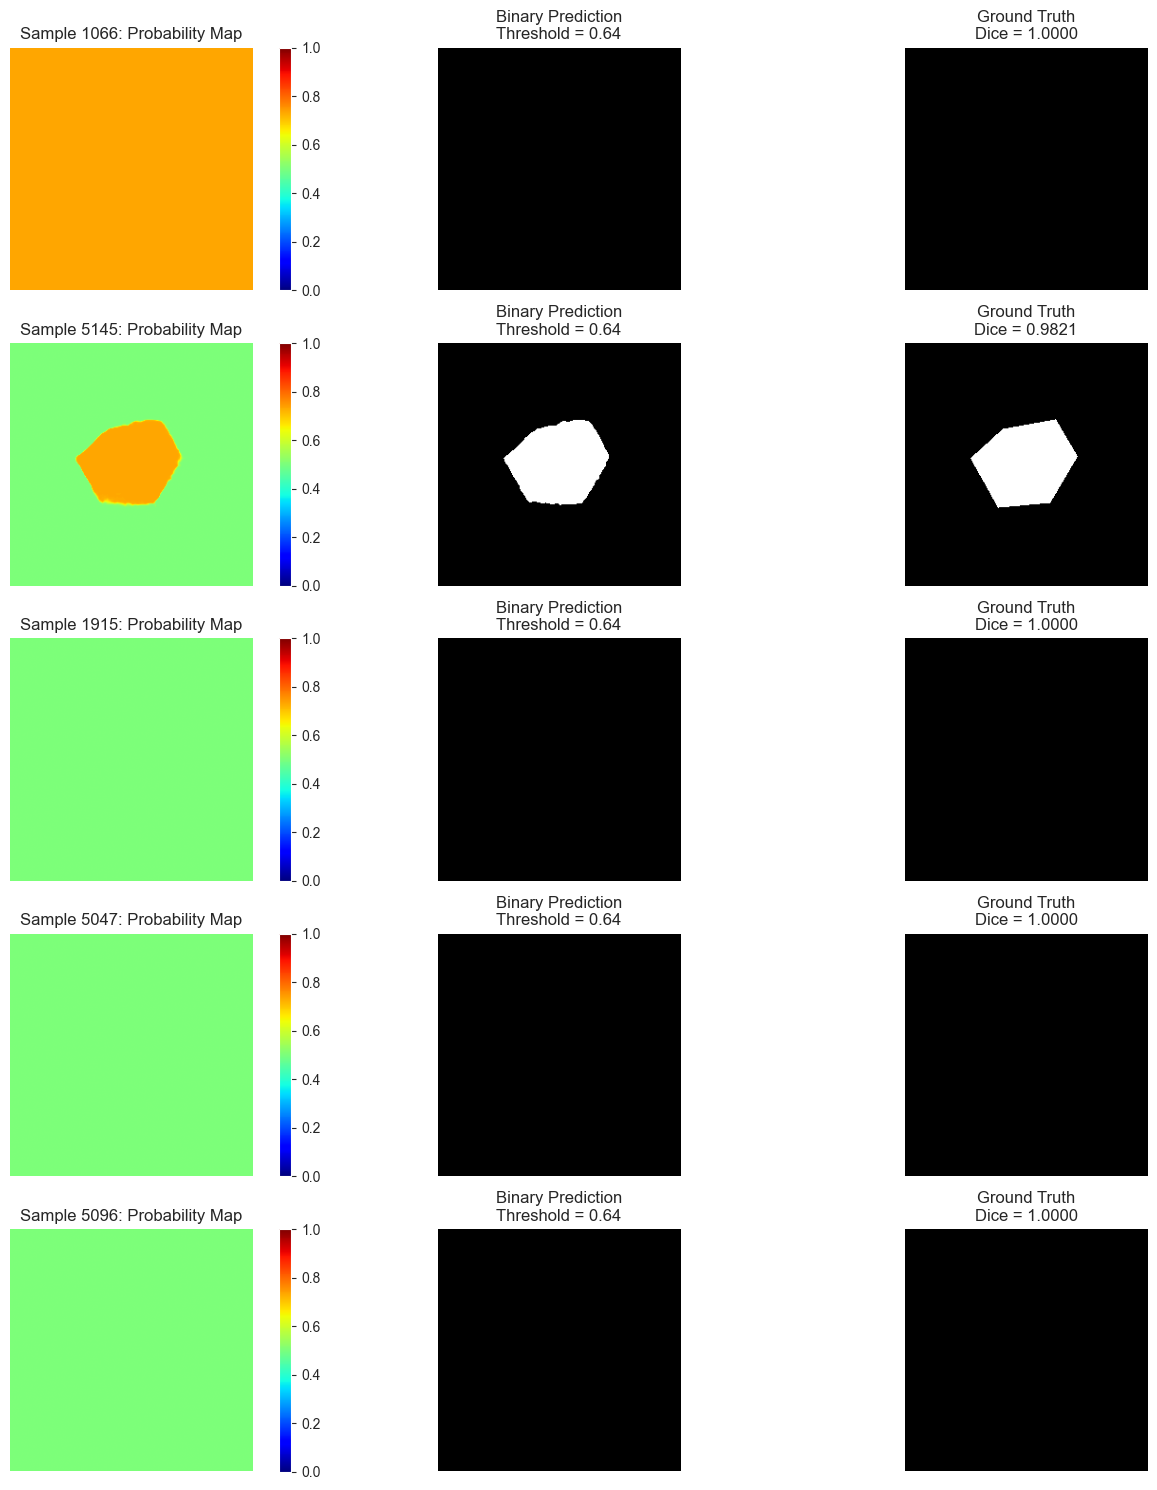

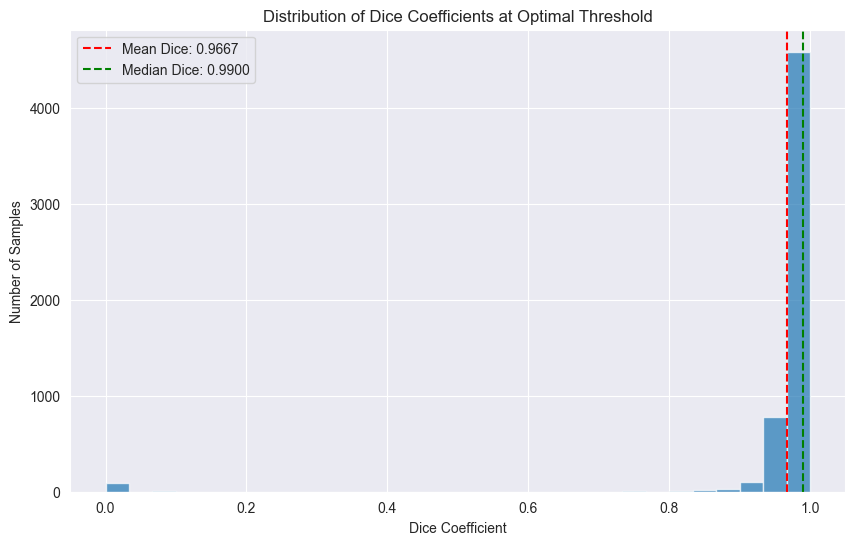

Saved optimal threshold (0.6368) to optimal_threshold.npz

Calculating per-image optimal thresholds...


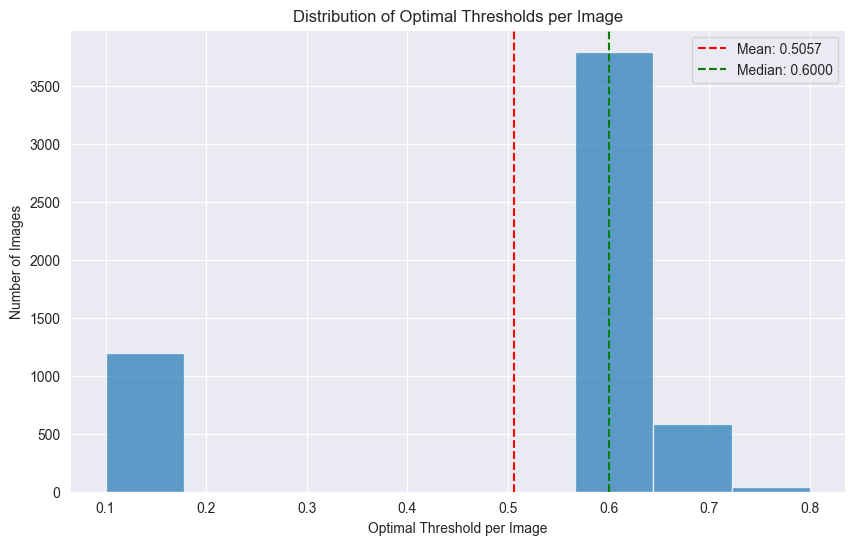

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Using standard tqdm instead of tqdm.notebook
from sklearn.metrics import precision_recall_curve, auc
import pandas as pd
import seaborn as sns

# Function to calculate Dice coefficient
def dice_coefficient(y_true, y_pred):
    """
    Calculate Dice coefficient between two binary masks

    Args:
        y_true: ground truth binary mask
        y_pred: predicted binary mask

    Returns:
        dice: Dice coefficient
    """
    intersection = np.sum(y_true * y_pred)
    smooth = 1e-6  # to avoid division by zero
    dice = (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
    return dice

# Load validation predictions and ground truth
data = np.load('your_model_path/validation.npz')
mask_preds = data['mask_preds']  # shape: (num_samples, height, width)
real_masks = data['real_masks']  # shape: (num_samples, height, width)

print(f"Loaded validation data: {mask_preds.shape} predictions, {real_masks.shape} ground truth masks")

# Define thresholds to test
thresholds = np.linspace(0.4, 0.7, 20)  # Test thresholds from 0.1 to 0.9 with 17 steps

# Calculate Dice coefficient for each threshold
dice_scores = []
sample_dice_scores = []  # For storing per-sample scores

for threshold in tqdm(thresholds, desc="Testing thresholds"):
    # Apply threshold to predictions
    binary_preds = (mask_preds > threshold).astype(np.float32)

    # Calculate Dice coefficient for each sample
    sample_scores = []
    for i in range(len(binary_preds)):
        dice = dice_coefficient(real_masks[i], binary_preds[i])
        sample_scores.append(dice)

    # Store per-sample scores for this threshold
    sample_dice_scores.append(sample_scores)

    # Calculate average Dice coefficient for this threshold
    mean_dice = np.mean(sample_scores)
    dice_scores.append(mean_dice)

# Find the optimal threshold
optimal_threshold_idx = np.argmax(dice_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
optimal_dice = dice_scores[optimal_threshold_idx]

print(f"Optimal threshold: {optimal_threshold:.3f} with Dice coefficient: {optimal_dice:.4f}")

# Create a DataFrame for easier analysis
result_df = pd.DataFrame({
    'Threshold': thresholds,
    'Mean_Dice': dice_scores
})
print("\nThreshold results:")
print(result_df)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(thresholds, dice_scores, 'o-', linewidth=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--',
            label=f'Optimal threshold: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Mean Dice Coefficient')
plt.title('Dice Coefficient vs Threshold')
plt.grid(True)
plt.legend()

# Create boxplot for per-sample Dice scores at each threshold
plt.subplot(1, 2, 2)
df = pd.DataFrame(sample_dice_scores).T
df.columns = [f'{t:.2f}' for t in thresholds]
sns.boxplot(data=df)
plt.axvline(x=optimal_threshold_idx, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Dice Coefficient')
plt.title('Distribution of Dice Scores per Threshold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate precision-recall curve
y_true_flat = real_masks.flatten()
y_scores_flat = mask_preds.flatten()
precision, recall, pr_thresholds = precision_recall_curve(y_true_flat, y_scores_flat)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

# Visualize some example predictions with optimal threshold
def plot_samples(original_preds, binary_preds, ground_truth, n_samples=5):
    """
    Plot sample predictions with both original probability maps and binary predictions
    """
    indices = np.random.choice(len(binary_preds), min(n_samples, len(binary_preds)), replace=False)

    plt.figure(figsize=(15, 3*n_samples))
    for i, idx in enumerate(indices):
        # Original prediction
        plt.subplot(n_samples, 3, i*3+1)
        plt.imshow(original_preds[idx], cmap='jet', vmin=0, vmax=1)
        plt.colorbar()
        plt.title(f'Sample {idx}: Probability Map')
        plt.axis('off')

        # Binary prediction
        plt.subplot(n_samples, 3, i*3+2)
        plt.imshow(binary_preds[idx], cmap='gray')
        plt.title(f'Binary Prediction\nThreshold = {optimal_threshold:.2f}')
        plt.axis('off')

        # Ground truth
        plt.subplot(n_samples, 3, i*3+3)
        plt.imshow(ground_truth[idx], cmap='gray')
        dice = dice_coefficient(ground_truth[idx], binary_preds[idx])
        plt.title(f'Ground Truth\nDice = {dice:.4f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Apply optimal threshold to get binary predictions
optimal_binary_preds = (mask_preds > optimal_threshold).astype(np.float32)

# Plot some sample predictions
plot_samples(mask_preds, optimal_binary_preds, real_masks)

# Additional analysis: Histogram of Dice scores with optimal threshold
dice_values = [dice_coefficient(real_masks[i], optimal_binary_preds[i]) for i in range(len(optimal_binary_preds))]

plt.figure(figsize=(10, 6))
plt.hist(dice_values, bins=30, alpha=0.7)
plt.axvline(x=np.mean(dice_values), color='r', linestyle='--',
            label=f'Mean Dice: {np.mean(dice_values):.4f}')
plt.axvline(x=np.median(dice_values), color='g', linestyle='--',
            label=f'Median Dice: {np.median(dice_values):.4f}')
plt.xlabel('Dice Coefficient')
plt.ylabel('Number of Samples')
plt.title('Distribution of Dice Coefficients at Optimal Threshold')
plt.legend()
plt.grid(True)
plt.show()

